In [37]:
import pandas as pd
pd.set_option('display.max_columns', 500)
from google.colab import drive

drive.mount('/content/gdrive')
df = pd.read_csv('gdrive/My Drive/events.csv')

#drop everything besides attempts
df = df[df['event_type'] == 1]

#select features I will definitely use
df = df[['location', 'bodypart', 'assist_method', 'situation', 'fast_break', 'is_goal']]

df.head()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


,location,bodypart,assist_method,situation,fast_break,is_goal
0,9.0,2.0,1,1.0,0,0
11,15.0,1.0,1,1.0,0,0
13,9.0,2.0,1,1.0,0,1
14,15.0,1.0,0,1.0,0,0
17,15.0,1.0,0,1.0,0,0


Let's deal with missing values:

0


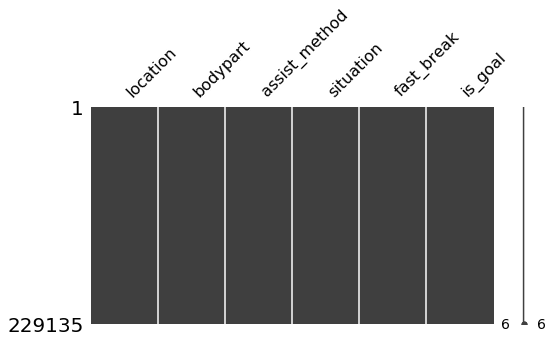

In [38]:
import missingno as mn

mn.matrix(df, figsize=(8, 4))
print(df.isna().sum().sum())

Perfect! But we know that '19' in the location column means 'not recorded'. Let's fix it now.

In [39]:
print((df['location'] == 19).sum())
df = df.drop(df[df['location'] == 19].index)
print((df['location'] == 19).sum())

1450
0


Now onto the categorical variables. Firstly, for the sake of explainability, I will replace numbers with words.**bold text**

In [40]:
locations = {1: 'attacking_half',
            2: 'defensive_half',
            3: 'centre_of_the_box',
            4: 'left_wing',
            5: 'right_wing',
            6: 'diff_angle_and_long_range',
            7: 'diff_angle_left',
            8: 'diff_angle_right',
            9: 'left_of_the_box',
            10: 'left_of_6y_box',
            11: 'right_of_the_box',
            12: 'right_of_6y_box',
            13: 'very_close_range',
            14: 'penalty_spot',
            15: 'outside_the_box',
            16: 'long_range',
            17: 'more_than_35y',
            18: 'more_than_40y'}

body_parts = {1: 'right',
             2: 'left',
             3: 'head'}

assist_methods = {0: 'none',
                  1: 'pass',
                  2: 'cross',
                  3: 'header',
                  4: 'through_ball'}

situations = {1: 'open_play',
              2: 'set_piece',
              3: 'corner',
              4: 'free_kick'}

df['location'] = list(map(locations.get, df['location']))
df['bodypart'] = list(map(body_parts.get, df['bodypart']))
df['assist_method'] = list(map(assist_methods.get, df['assist_method']))
df['situation'] = list(map(situations.get, df['situation']))

df.head()

,location,bodypart,assist_method,situation,fast_break,is_goal
0,left_of_the_box,left,pass,open_play,0,0
11,outside_the_box,right,pass,open_play,0,0
13,left_of_the_box,left,pass,open_play,0,1
14,outside_the_box,right,none,open_play,0,0
17,outside_the_box,right,none,open_play,0,0


Great! So now we can finally encode them.

In [41]:
#encode
df = pd.get_dummies(df, columns=['location', 'bodypart', 'assist_method', 'situation'], drop_first=False)

df.head()

,fast_break,is_goal,location_centre_of_the_box,location_diff_angle_and_long_range,location_diff_angle_left,location_diff_angle_right,location_left_of_6y_box,location_left_of_the_box,location_long_range,location_more_than_35y,location_more_than_40y,location_outside_the_box,location_penalty_spot,location_right_of_6y_box,location_right_of_the_box,location_very_close_range,bodypart_head,bodypart_left,bodypart_right,assist_method_cross,assist_method_header,assist_method_none,assist_method_pass,assist_method_through_ball,situation_corner,situation_free_kick,situation_open_play,situation_set_piece
0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0
11,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
13,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0
14,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0
17,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0


For the last step, let's plot the correlation map.

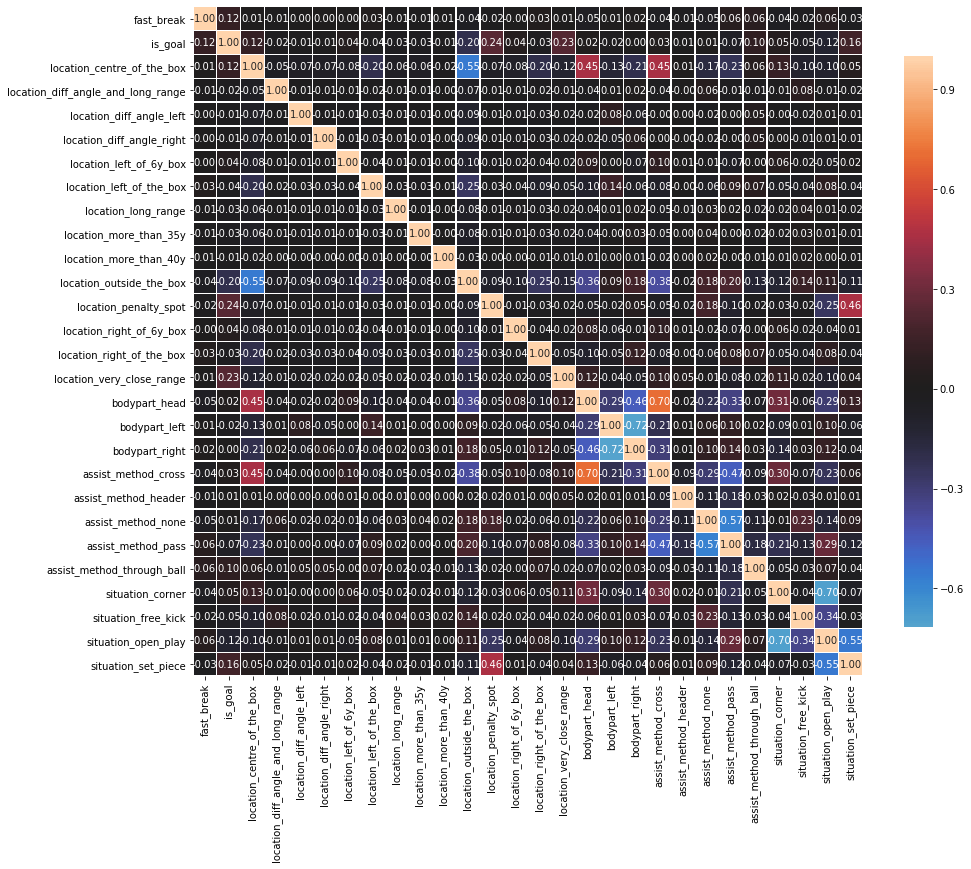

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(df.corr(), vmax=1.0, center=0, fmt='.2f',
            square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
plt.show();

In [0]:
df = df.sample(frac=1)
df.to_csv('data.csv', index=False)